In [1]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from preprocess.focal_loss import FocalLoss
# from utils.svdd_loss import SVDDLoss
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.svdd_net import FusionNet
from utils.reconstruction_loss import ReconstructionLoss_audio as ReconstructionLoss
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

train_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_test'
train_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_test'

test_audio = '/home/iot/collision_detect/new_data/audio_np/Abnormal'
test_imu = '/home/iot/collision_detect/new_data/imu_np/Abnormal'


checkpoint_path = '/home/iot/collision_detect/output/ours_fusion_1/last_model.pth'

workers = 4
batchsize = 64
dropout_rate = 0.3
kernel_num = 32
feature_dim = 128
num_class = 2
use_attention = 1
Epoch = 200


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = ReconstructionLoss()
loss_function = nn.MSELoss()


train_data = CollisionLoader_new(train_imu,train_audio,train=True)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

random_tensor = torch.load('/home/iot/collision_detect/svdd/center_2.pth').to(device)
print(random_tensor.shape)
model = FusionNet(use_crossattention=use_attention, feature_dim=feature_dim, dropout_rate=dropout_rate, kernel_num=kernel_num, classes=num_class)
model = model.to(device)

if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
    print('Load weights')


cuda
torch.Size([256])
Load weights


Reconstruction Loss 0.0014
SVDD Loss for Sample: 0.0019


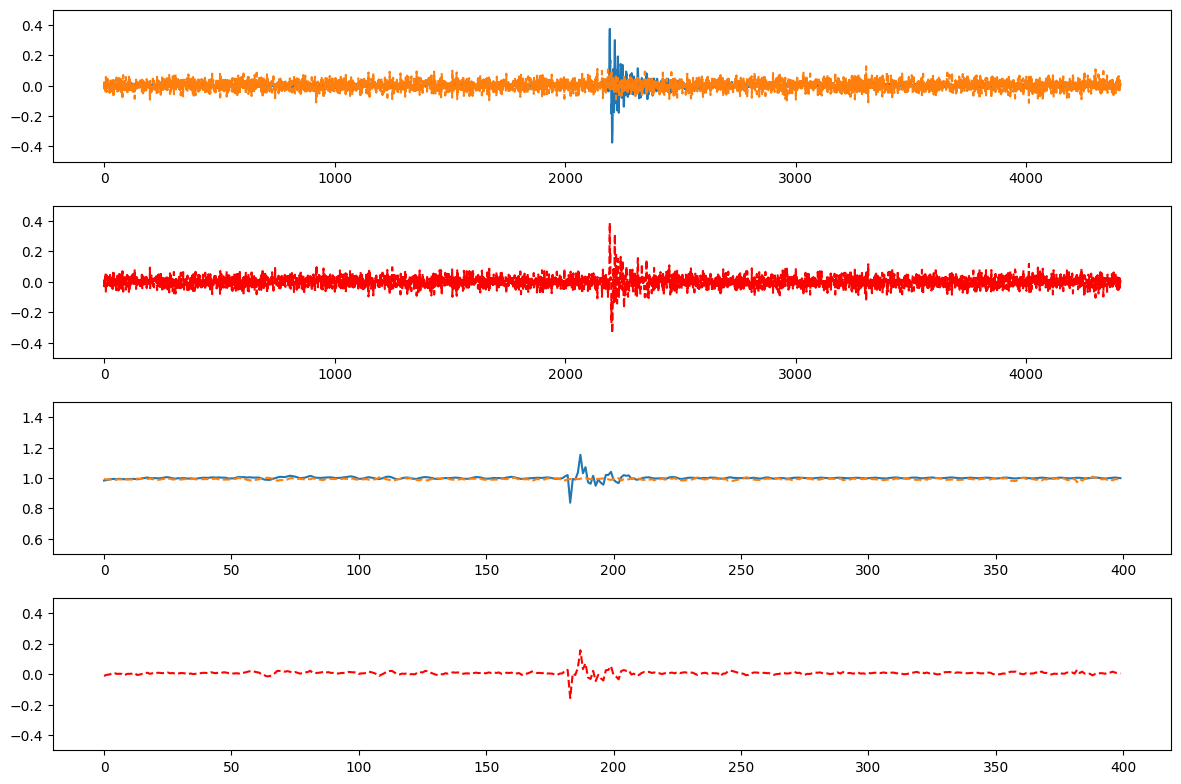

In [2]:
model.eval()
sample_idx = 293# p
# Assuming the necessary libraries and data are already imported and available in the current context

# Your existing code to get the anomaly score, reconstructed audio, and reconstructed IMU
spec, image, audio, _, _ = val_data[sample_idx]
spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)
reconstruction_loss = reconstruction_loss_fn(audio, reconstructed_audio)

target_zero = random_tensor.unsqueeze(0).expand(1, -1)
svdd_loss = loss_function(anomaly_score, target_zero)
total_loss = svdd_loss + reconstruction_loss

# Print the losses
print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
print(f"SVDD Loss for Sample: {svdd_loss.item():.4f}")

# Prepare data for plotting
original_audio = audio.cpu().detach().numpy().squeeze()[0]
reconstructed_audio = reconstructed_audio.cpu().detach().numpy().squeeze()[0]

original_imu = image.cpu().detach().numpy().squeeze()
reconstructed_imu = reconstructed_imu.cpu().detach().numpy().squeeze()
# Calculate errors
audio_error = original_audio - reconstructed_audio
imu_error = original_imu - reconstructed_imu

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

# Original and reconstructed audio signals
axes[0].plot(original_audio, label='Original Audio')
axes[0].plot(reconstructed_audio, label='Reconstructed Audio', linestyle='dashed')
# axes[0].legend()
# axes[0].set_title('Original and Reconstructed Audio')
axes[0].set_ylim(-0.5, 0.5)

# Error in audio signals
axes[1].plot(audio_error, label='Audio Error', color='red',linestyle='dashed')
# axes[1].legend()
# axes[1].set_title('Audio Reconstruction Error')
axes[1].set_ylim(-0.5, 0.5)

# Original and reconstructed IMU signals
axes[2].plot(original_imu, label='Original IMU')
axes[2].plot(reconstructed_imu, label='Reconstructed IMU', linestyle='dashed')
# axes[2].legend()
# axes[2].set_title('Original and Reconstructed IMU')
axes[2].set_ylim(0.5, 1.5)

# Error in IMU signals
axes[3].plot(imu_error, label='IMU Error', color='red', linestyle='dashed')
# axes[3].legend()
# axes[3].set_title('IMU Reconstruction Error')
axes[3].set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()



torch.Size([1, 256])
Reconstruction Loss 0.0004
SVDd Loss for Sample: 0.0025


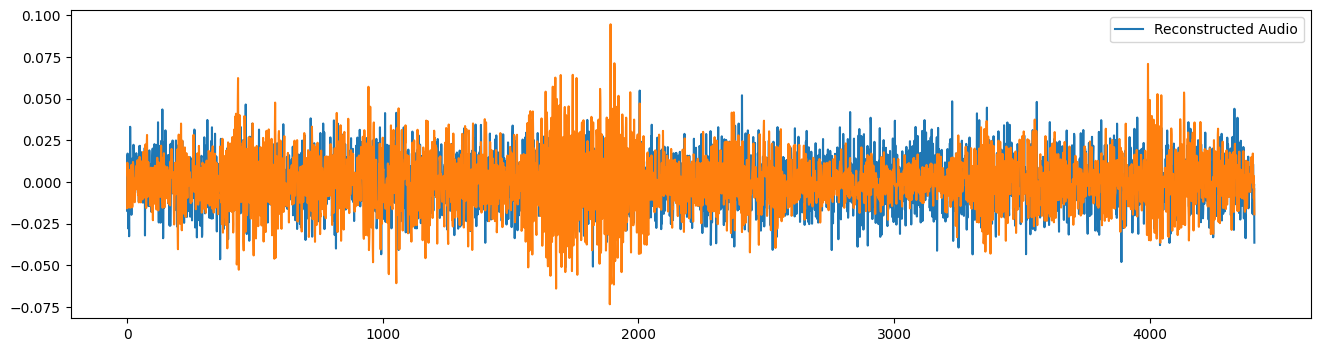

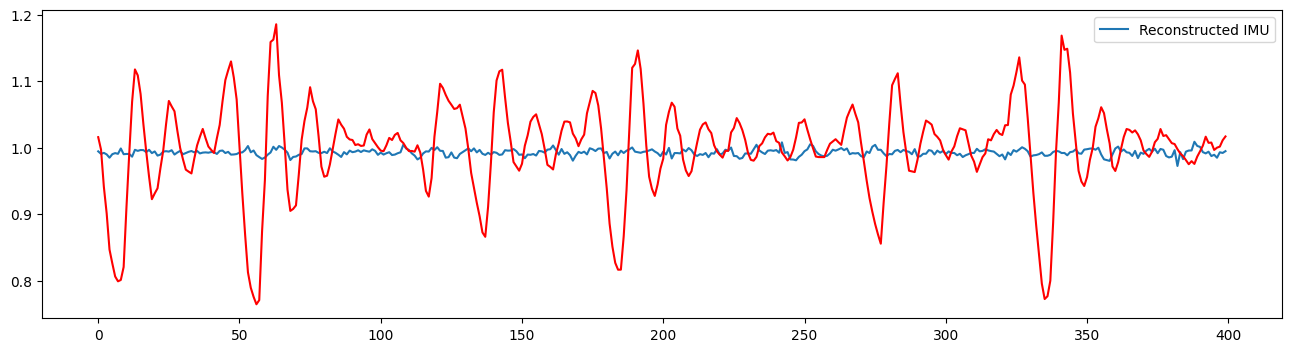

In [6]:
model.eval()
sample_idx = 693# print(audio.shape)5
# Change this to the index of the sample you want to load
spec, image, audio,_,_ = val_data[sample_idx]
spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

anomaly_score, reconstructed_audio, reconstructed_imu= model(audio, image)
print(anomaly_score.shape)
reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio)
target_zero = random_tensor.unsqueeze(0).expand(1, -1)
svdd_loss = loss_function(anomaly_score, target_zero)
total_loss = svdd_loss+reconstruction_loss

print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
print(f"SVDd Loss for Sample: {svdd_loss.item():.4f}")
plt.figure(figsize=(16, 4))
plt.plot(reconstructed_audio.cpu().detach().numpy().squeeze()[0], label='Reconstructed Audio')
plt.plot(audio.cpu().numpy().squeeze()[0])
plt.legend()

plt.figure(figsize=(16, 4))
plt.plot(reconstructed_imu.cpu().detach().numpy().squeeze(), label='Reconstructed IMU')
plt.plot(image.cpu().numpy().squeeze(), 'r')
plt.legend()


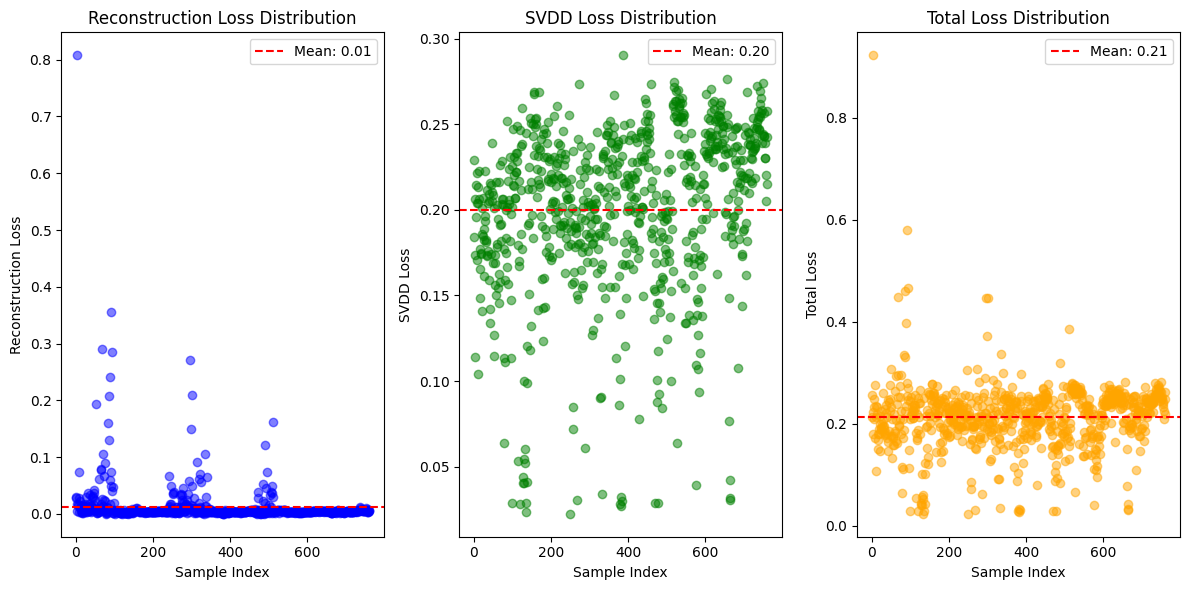

In [34]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_val = []
svdd_losses_val = []
total_losses_val = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio,_,_ = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # print(image.shape,audio.shape,sample_idx)
    # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn( audio[:,:,:-100], reconstructed_audio[:,:,:-100]) * 10

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample
        svdd_loss = loss_function(anomaly_score, target_zero)*100

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses_val.append(reconstruction_loss.item())
        svdd_losses_val.append(svdd_loss.item())
        total_losses_val.append(total_loss.item())
        total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_val) / len(reconstruction_losses_val)
mean_svdd_loss = sum(svdd_losses_val) / len(svdd_losses_val)
mean_total_loss = sum(total_losses_val) / len(total_losses_val)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses_val, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses_val, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses_val), 0.32)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses_val, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses),2)
plt.legend()

plt.tight_layout()
plt.show()

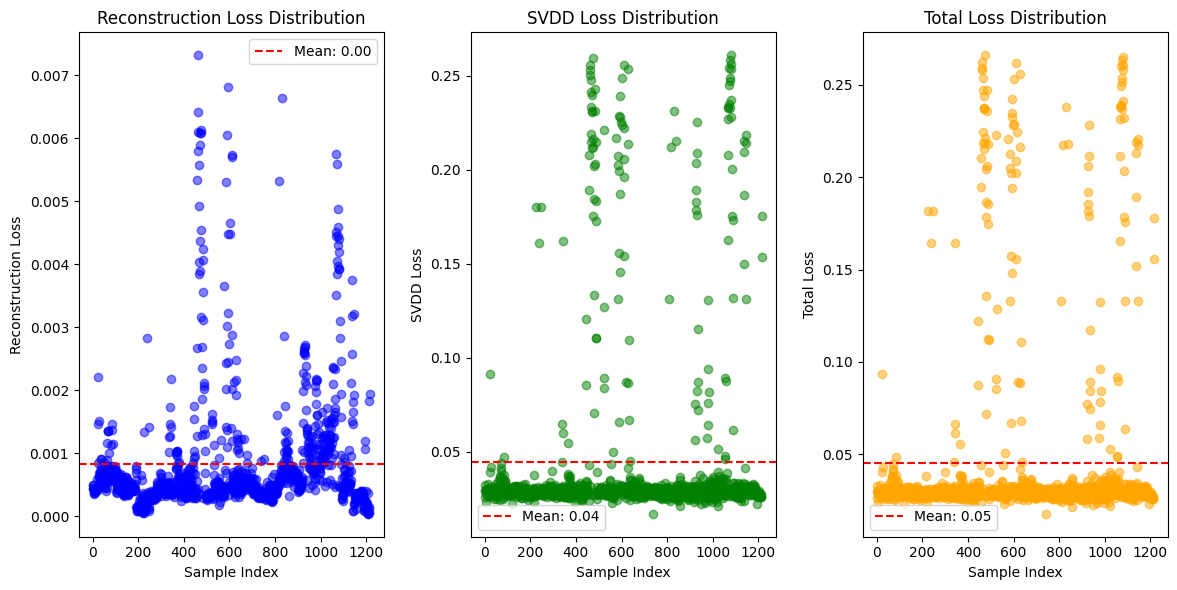

In [35]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_train = []
svdd_losses_train = []
total_losses_train = []

# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio,_,_ = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn( audio[:,:,:-100], reconstructed_audio[:,:,:-100]) * 10

        # Generate random tensor for SVDD loss
        target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample0
        svdd_loss = loss_function(anomaly_score, target_zero)*100

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses_train.append(reconstruction_loss.item())
        svdd_losses_train.append(svdd_loss.item())
        total_losses_train.append(total_loss.item())

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_train) / len(reconstruction_losses_train)
mean_svdd_loss = sum(svdd_losses_train) / len(svdd_losses_train)
mean_total_loss = sum(total_losses_train) / len(total_losses_train)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(train_data)), reconstruction_losses_train, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), max(reconstruction_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses_train, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(train_data)), total_losses_train, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses), max(total_losses)*1.1)
plt.legend()

plt.tight_layout()
plt.show()

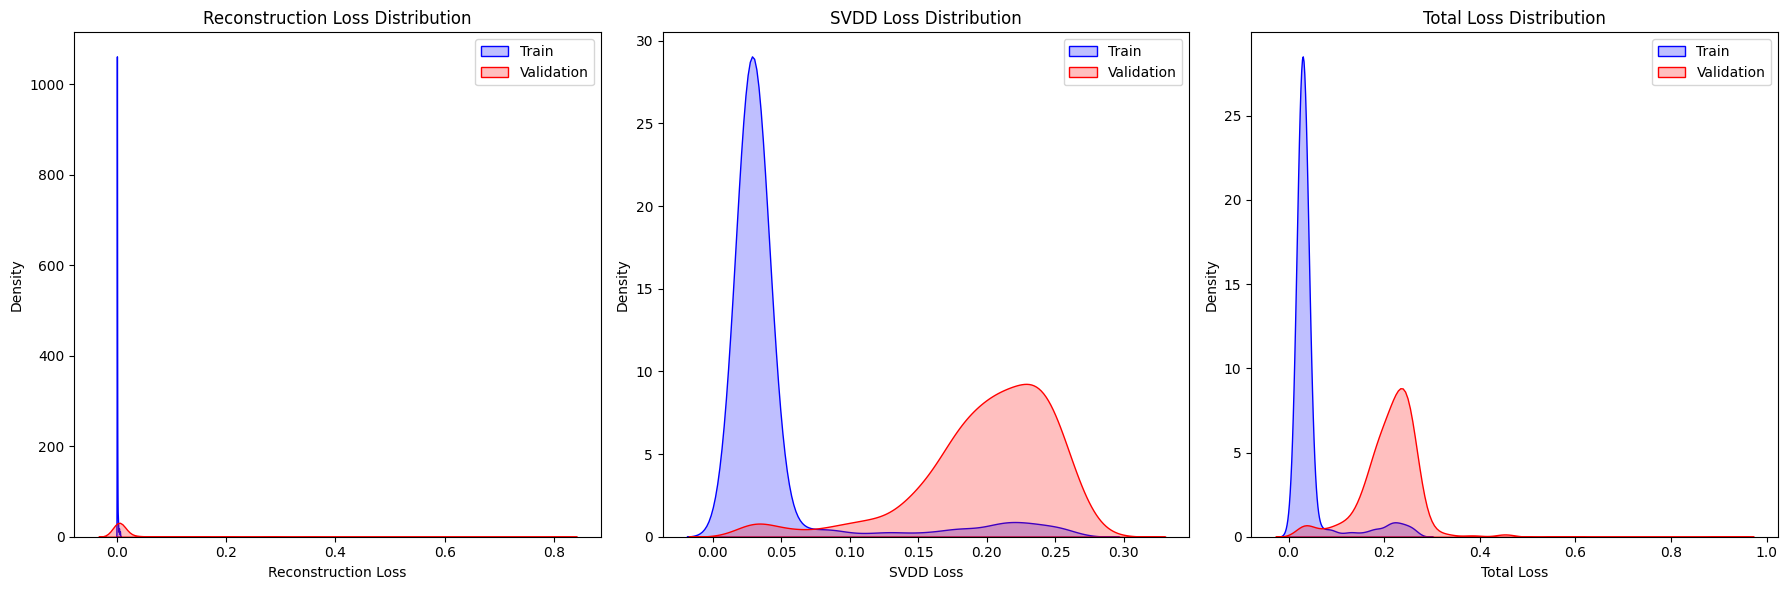

In [36]:
import seaborn as sns

# Plotting KDE plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(reconstruction_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(reconstruction_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(svdd_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(svdd_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 40)
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(total_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(total_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


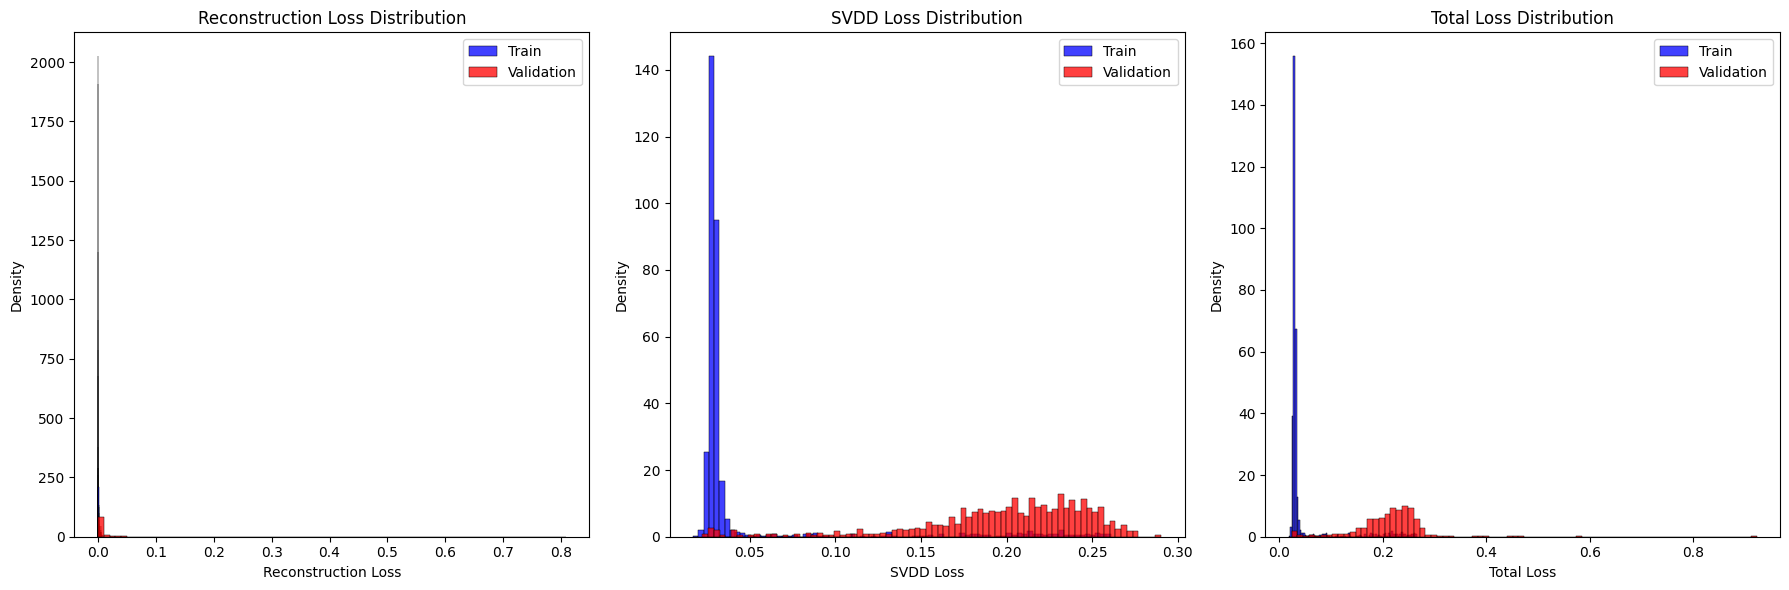

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting histograms
plt.figure(figsize=(18, 6))

# Plot for Reconstruction Loss Distribution
plt.subplot(1, 3, 1)
sns.histplot(reconstruction_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(reconstruction_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

# Plot for SVDD Loss Distribution
plt.subplot(1, 3, 2)
sns.histplot(svdd_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(svdd_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 0.4)
plt.legend()

# Plot for Total Loss Distribution
plt.subplot(1, 3, 3)
sns.histplot(total_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(total_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')

plt.legend()

plt.tight_layout()
plt.show()


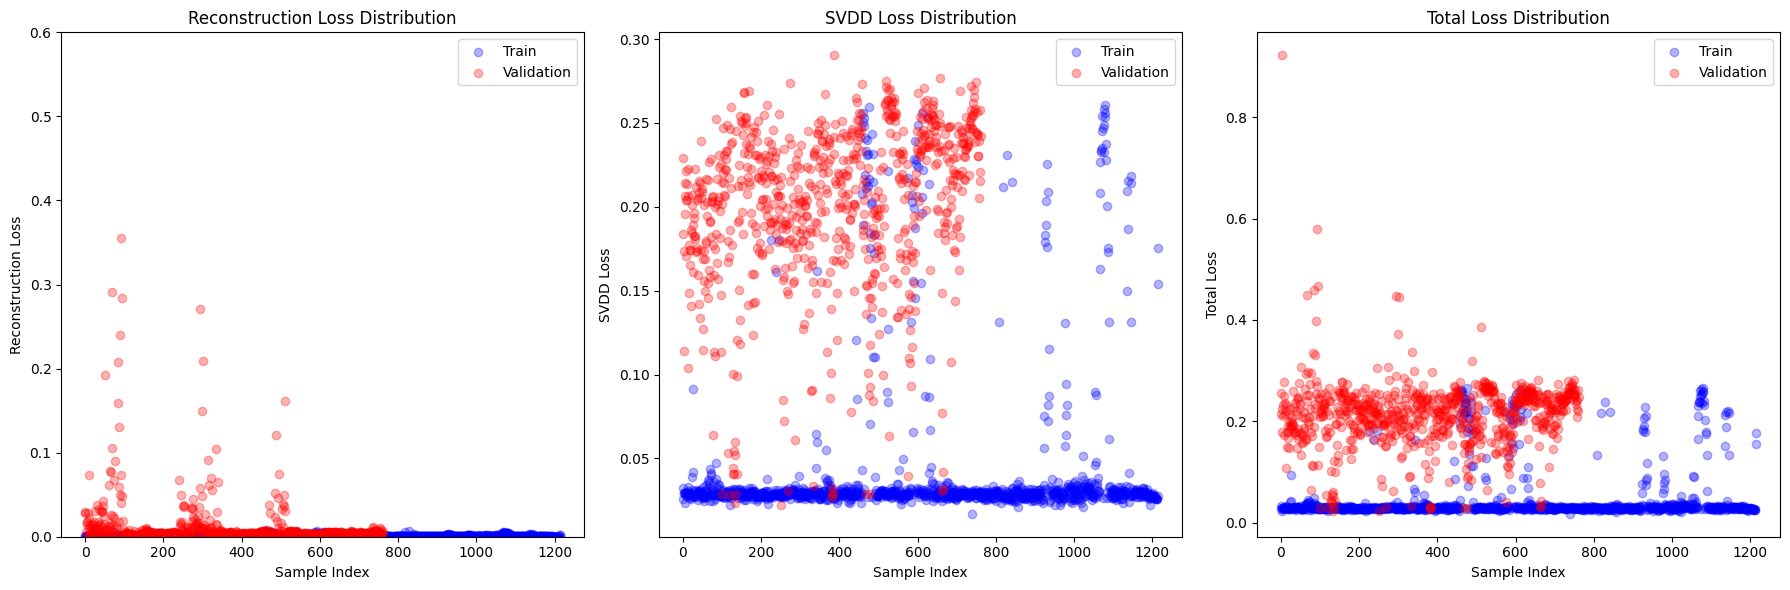

In [44]:
import matplotlib.pyplot as plt

# Plotting scatter plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(reconstruction_losses_train)), reconstruction_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(reconstruction_losses_val)), reconstruction_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(0,0.6)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(svdd_losses_train)), svdd_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(svdd_losses_val)), svdd_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
# plt.ylim(0,0.3)
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(total_losses_train)), total_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(total_losses_val)), total_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
# plt.ylim(0,1)
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
train_data.audio_list[450]

'/home/iot/collision_detect/new_data/audio_np/Normal_test/seq10/29.npy'

In [40]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data


loss_all_audio = svdd_losses_train+svdd_losses_val
loss_all_audio = np.array(loss_all_audio)
loss_all_audio = z_score_normalization(loss_all_audio)


loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)
loss_all_recons = z_score_normalization(loss_all_recons)

In [41]:
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [0.5*x + 0.5*y for x, y in zip(loss_all_audio, loss_all_recons)]

In [42]:
eval_metrics_svdd = ts_metrics(labels_all, (loss_all_audio))
eval_metrics_recons = ts_metrics(labels_all, (loss_all_recons))
eval_metrics_all = ts_metrics(labels_all, (loss_all))

In [43]:
print(eval_metrics_svdd)
print(eval_metrics_recons)
print(eval_metrics_all)

(0.9493067067274485, 0.8847019240602526, 0.9133115920640901, 0.8759036144578313, 0.9540682414698163)
(0.9622422813924576, 0.9311515290364402, 0.9023387503328779, 0.8953488372093024, 0.9094488188976378)
(0.9568375293548832, 0.915615835991269, 0.9118337990806815, 0.8765133171912833, 0.9501312335958005)


In [18]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# model.eval()
# random_tensor = torch.load('center.pth').to(device)
# true_labels = []
# predicted_labels = []
# threshold = 0.45

# with torch.no_grad():
#     for sample_idx in range(len(val_data)):
#         spec, image, audio = val_data[sample_idx]

#         spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

#         anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

#         reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio, reconstructed_audio) * 10

#         target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

#         # Calculate SVDD loss for the sample
#         svdd_loss = loss_function(anomaly_score, target_zero)*100

#         # Calculate total loss for the sample
#         total_loss = svdd_loss + reconstruction_loss

#         # Predict class based on total loss
#         if svdd_loss<=mean_svdd_loss:
#             predicted_class=0
#         else:
#             predicted_class=1

#         # Handle ground truth class
#         true_class = 1

#         # Update confusion matrix variables
#         true_labels.append(true_class)
#         predicted_labels.append(predicted_class)

# # Construct confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# print("Confusion Matrix:")
# print(conf_matrix)


In [10]:
conf_matrix = np.array([[267, 105],[48, 278]])

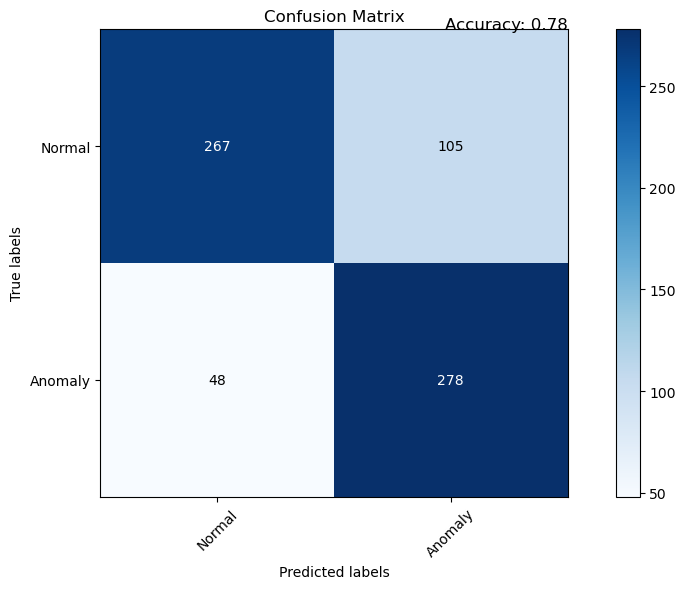

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Normal', 'Anomaly']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add counts to each cell
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Add accuracy to the plot
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', color='black', fontsize=12, horizontalalignment='right')

# Eliminate grid lines
plt.grid(False)

plt.tight_layout()
plt.show()


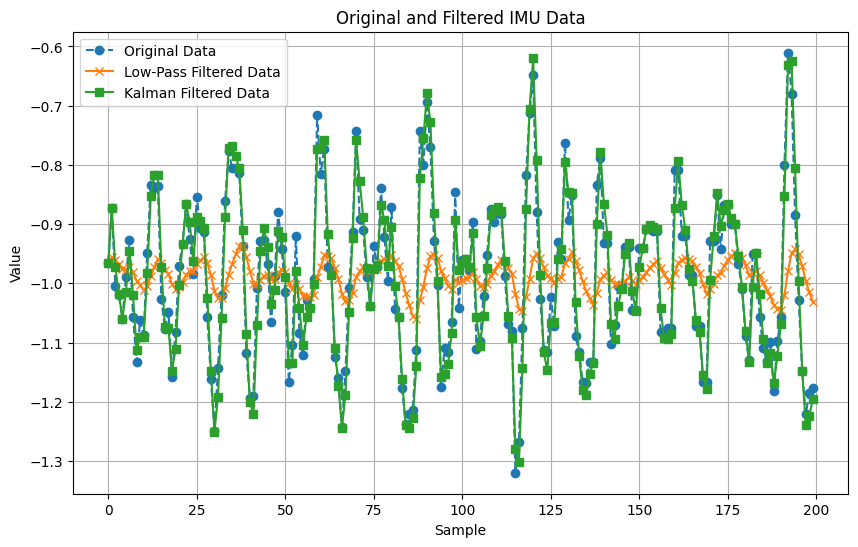

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Low-Pass Filter Class
class LowPassFilter:
    def __init__(self, alpha):
        self.alpha = alpha
        self.state = None

    def filter(self, value):
        if self.state is None:
            self.state = value
        else:
            self.state = self.alpha * value + (1 - self.alpha) * self.state
        return self.state

# Kalman Filter Function
def apply_kalman_filter(data, R, Q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # initial state (position and velocity)
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = R  # measurement noise
    kf.Q = Q  # process noise

    filtered_data = []

    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])  # we are interested in the position

    return np.array(filtered_data)

# Example IMU data (numpy array)
imu_data = np.load('/home/iot/collision_detect/data/imu/normal_train/normal_5/85.npy')[:,-1][:1000]
# Apply Low-Pass Filter
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in imu_data])

# Apply Kalman Filter
R = 0.1  # Example measurement noise
Q = 0.1  # Example process noise
kf_filtered_data = apply_kalman_filter(imu_data, R, Q)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(imu_data, label='Original Data', linestyle='--', marker='o')
plt.plot(lpf_filtered_data, label='Low-Pass Filtered Data', linestyle='-', marker='x')
plt.plot(kf_filtered_data, label='Kalman Filtered Data', linestyle='-', marker='s')

plt.title('Original and Filtered IMU Data')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
x = np.load('/home/iot/collision_detect/new_data/imu_np/Abnormal/fl/20.npy')[:,-1]
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in x])

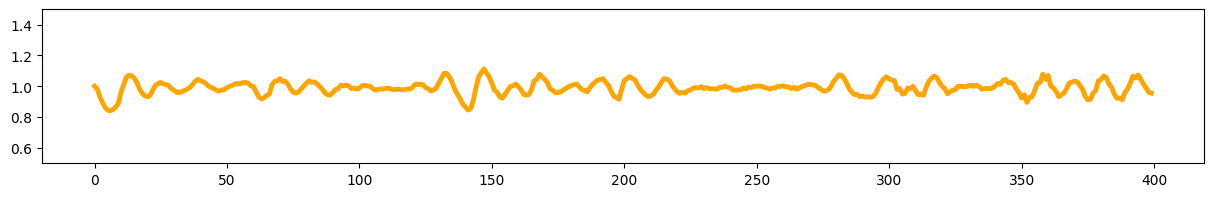

In [66]:
plt.figure(figsize=(15, 2))
plt.ylim(0.5,1.5)
plt.plot(lpf_filtered_data,color='orange',linewidth=3.5)

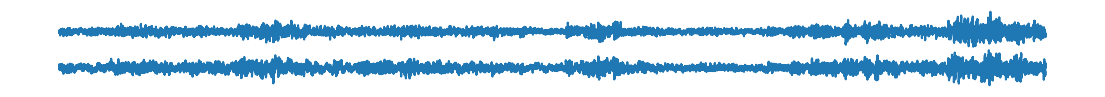

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Load the audio data
audio_data = np.load('/home/iot/collision_detect/new_data/audio_np/Abnormal/fl/20.npy')

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 1))

# Plot the first audio signal
axs[0].plot(audio_data[0])
axs[0].axis('off')  # Turn off the axis
# axs[0].set_ylim(-0.1, 0.1) 
# Plot the second audio signal
axs[1].plot(audio_data[1])
axs[1].axis('off')  # Turn off the axis
# axs[1].set_ylim(-0.1, 0.1) 
# Adjust layout to have no space between plots
plt.subplots_adjust(hspace=0.001)

# Display the plot
plt.show()
